# Plotting Script for Plotting B/G color MEI bias 

In [3]:
%load_ext autoreload
%autoreload 2

import datajoint as dj

dj.config["display.limit"] = 50
dj.config["enable_python_native_blobs"] = True
dj.config['schema_name'] = "nnfabrik_color_mei"
schema = dj.schema("nnfabrik_color_mei")

from matplotlib import pyplot as plt
from torch import load

from nnfabrik.main import *

import nnfabrik
from collections import namedtuple
from nnfabrik import main, builder
import os
from os import listdir
from os.path import isfile, join
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm

from mlutils.data.datasets import StaticImageSet, FileTreeDataset
from nndichromacy.tables.from_nnfabrik import TrainedModel, DataInfo
from dataport.bcm.static import PreprocessedMouseData
from nnvision.utility.measures import get_explainable_var

from nndichromacy.tables.from_mei import MEI, TrainedEnsembleModel, MEISelector, MEIMethod, MEISeed

Connecting kwilleke@134.2.168.16:3306


### Select a dataset and method hash. If there is more than one ensemble for that dataset, chose an ensemble_hash instead.

In [17]:
experiment = dj.create_virtual_module('experiment', 'sinzlab_houston_data')


In [14]:
dataset_hashes = ['5782393e87b00cbe3d47577f61175069',
                  '843b75ca3aa6214dadf308886ad2daaa',
                  'ce8894b5baa4157138d43d9734f402b8'
                 ]

In [27]:
cmap = sns.blend_palette(['#9b59b6', '#2ecc71',], as_cmap=True)

linewidths = 0.5
fontsize = 16

min_bias = 0.75
max_bias = 1.25

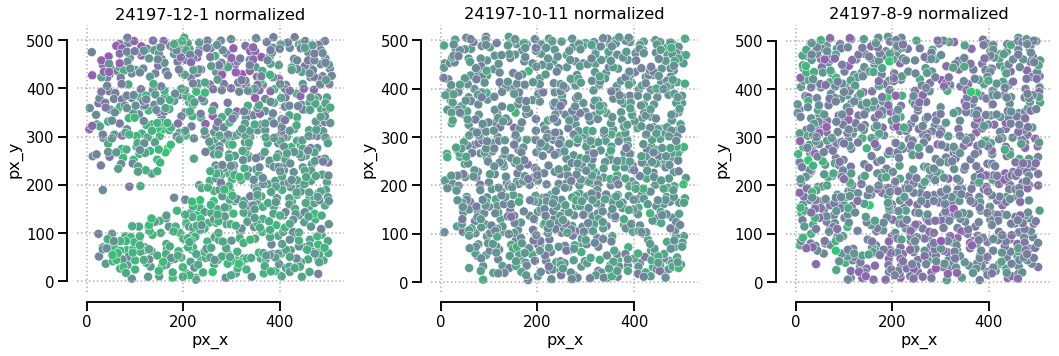

In [30]:
n_columns = len(dataset_hashes)

figure, axs = plt.subplots(1, n_columns, figsize=(15,25))
sns.set_context('talk', font_scale=0.9)

for i, ax in enumerate(axs.ravel()):
    
    dataset_hash = dataset_hashes[i]
    filename = (Dataset&dict(dataset_hash=dataset_hash)).fetch1("dataset_config")["paths"][0]
    scan_key = (PreprocessedMouseData & dict(filename=filename)).fetch("animal_id", "session", "scan_idx", as_dict=True)
    
    score_key = dict(dataset_hash=dataset_hash)
    title = (Dataset&dict(dataset_hash=dataset_hash)).fetch1("dataset_comment")
    
    # fetch MEIs, and cell coordinates
    px_x, px_y, mei_paths = (((MEI()&score_key)) * ((dj.U("unit_id", "px_x", "px_y")) & (experiment.ScanSet().UnitInfo & scan_key))).fetch("px_x", "px_y", "mei")
    
    #load MEIs and calculate bias
    MEIs = np.stack([torch.load(path).detach().cpu().numpy().squeeze() for path in mei_paths])
    mei_norm = np.empty((MEIs.shape[0], 2))
    for i, mei in enumerate(MEIs):
        mei_norm[i, 0] = (np.linalg.norm(mei[0,::]))
        mei_norm[i, 1] = (np.linalg.norm(mei[1,::]))
    mei_norm_zscore = mei_norm / np.linalg.norm(mei_norm, axis=1).mean()
    
    
    color = (mei_norm_zscore[:,0]/ mei_norm_zscore[:,1])
    ax.scatter(px_x, px_y,  edgecolors='w', linewidths=linewidths, c=color, cmap=cmap, vmin=min_bias, vmax=max_bias)
    
    ax.set_aspect('equal', 'box')
    ax.grid(True, linestyle=':')
    ax.set_xlabel("px_x", fontsize=fontsize)
    ax.set_ylabel("px_y", fontsize=fontsize)
    ax.set_title(title)

sns.despine(trim=True, offset=10)
plt.tight_layout()

# plt.savefig('MEI_bias_anatomical_positions.png', dpi=100, bbox_inches="tight")